# Notebook that generates my README

In [1]:
from datetime import datetime

import jinja2
import matplotlib.pyplot as plt
import mplcyberpunk

import generate_data as gd

plt.style.use("cyberpunk")

In [2]:
_ = await gd.generate_data()

2025-12-20 12:05:58,901 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-adaptive/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:58,922 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-kasa/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:58,927 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/topocm/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:59,128 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/pipefunc/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:59,216 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/kwant-project/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:59,307 INFO:httpx:HTTP Request: GET https://api.github.com/users/basnijholt/repos?type=sources "HTTP/1.1 200 OK"


2025-12-20 12:05:59,896 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=2 "HTTP/1.1 200 OK"


2025-12-20 12:06:00,403 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=3 "HTTP/1.1 200 OK"


2025-12-20 12:06:01,038 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=4 "HTTP/1.1 200 OK"


2025-12-20 12:06:01,570 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=5 "HTTP/1.1 200 OK"


2025-12-20 12:06:01,934 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=6 "HTTP/1.1 200 OK"


2025-12-20 12:06:02,242 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=7 "HTTP/1.1 200 OK"


2025-12-20 12:06:02,677 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=8 "HTTP/1.1 200 OK"


2025-12-20 12:06:03,017 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=9 "HTTP/1.1 200 OK"


2025-12-20 12:06:03,502 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=10 "HTTP/1.1 200 OK"


2025-12-20 12:06:04,506 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=11 "HTTP/1.1 200 OK"


2025-12-20 12:06:05,081 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=12 "HTTP/1.1 200 OK"


2025-12-20 12:06:05,510 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=13 "HTTP/1.1 200 OK"


2025-12-20 12:06:05,968 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=14 "HTTP/1.1 200 OK"


2025-12-20 12:06:06,280 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=15 "HTTP/1.1 200 OK"


2025-12-20 12:06:06,711 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:07,003 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:07,307 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:07,676 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:07,955 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:08,228 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:08,616 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:08,863 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:09,205 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:09,538 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:09,841 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:10,112 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:10,406 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:10,699 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:10,950 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:11,205 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:11,478 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:11,718 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:12,007 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:12,287 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:12,626 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:12,865 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:13,139 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:13,371 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:13,600 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:13,881 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:14,202 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:14,504 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:14,767 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:15,023 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:15,307 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:15,556 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:15,808 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:16,051 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:16,327 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:16,603 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:16,969 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:17,242 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:18,199 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:18,458 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:18,726 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:19,029 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:19,282 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:19,584 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:19,861 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:20,105 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:20,370 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:20,659 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:20,911 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:21,159 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:21,483 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:22,511 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:22,873 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:23,128 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:23,475 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:23,780 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:24,077 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:24,414 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:24,880 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:25,154 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:25,461 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:25,682 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:26,038 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:26,284 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:26,568 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:26,931 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:27,276 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:27,569 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:27,809 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:28,064 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:29,029 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:29,348 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:29,626 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:29,915 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:30,212 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:30,464 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:30,700 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:30,956 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:31,233 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:31,752 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:31,989 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:32,257 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:32,579 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:32,874 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:33,178 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:33,442 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:33,705 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:33,972 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:34,295 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:34,617 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:34,860 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:35,113 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:35,342 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:35,589 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:35,855 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:36,131 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:36,364 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:36,644 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:36,888 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:37,163 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:37,423 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:37,736 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:38,045 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:38,302 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:38,530 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:38,988 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:39,318 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:39,591 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:40,076 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:40,385 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:40,670 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:40,960 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:41,192 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:41,462 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:41,795 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:42,043 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:42,286 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:42,600 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:42,873 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:43,147 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:43,399 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:43,670 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:43,899 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:44,169 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:44,454 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:44,710 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:44,930 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:45,224 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:45,460 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:45,702 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:45,937 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:46,189 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:46,477 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2025-12-20 12:06:46,732 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


In [3]:
data = gd.load_data()
repos = data.repos
stargazers = data.stargazers

## Number of stars ⭐️

In [4]:
most_stars_strs = [
    f"{i+1}. [{repo['full_name']}](https://github.com/{repo['full_name']}/), {repo['stargazers_count']} ⭐️s"
    for i, repo in enumerate(stargazers[:20])
]

most_stars_strs_summary, most_stars_strs_rest = gd.split(most_stars_strs, 5)

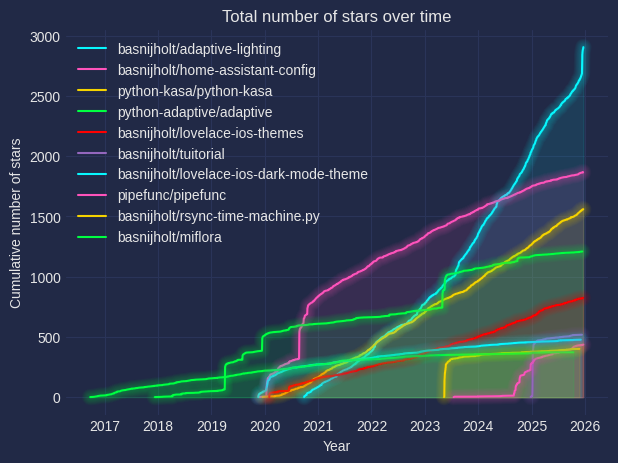

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")

for star_info in stargazers[:10]:
    dates = star_info["dates"]
    n_stars = list(range(1, len(dates) + 1))
    ax.plot(dates, n_stars, label=star_info["full_name"])
ax.legend()
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time_per_repo.png")

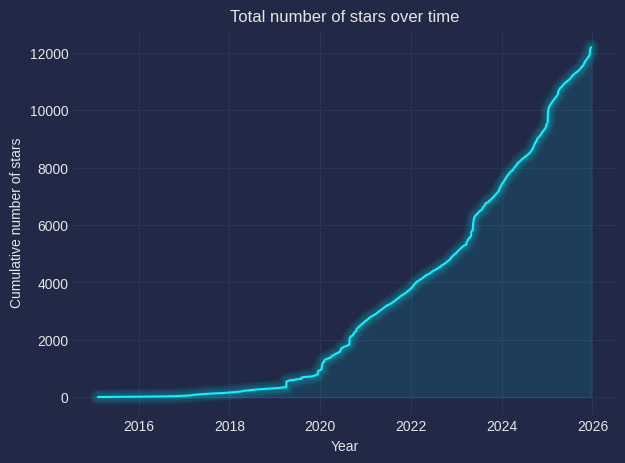

In [6]:
all_dates = sorted([date for star_info in stargazers for date in star_info["dates"]])
n_stars = list(range(1, len(all_dates) + 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(all_dates, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time.png")

In [7]:
# gd.to_plotly_json()

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# with open("data/traces_data.json", "r") as infile:
#     traces_data = json.load(infile)
# fig = make_subplots()
# for trace_data in traces_data:
#     trace = go.Scatter(**trace_data)
#     fig.add_trace(trace)
# fig.update_layout(
#     title="Cumulative number of stars over time",
#     xaxis_title="Date",
#     yaxis_title="Number of stars",
# )
# fig.show()


## Render template

In [8]:
with open("README.jinja2", "r") as f:
  template = f.read()
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

# Bas Nijholt 👋

<center>
  <table>
    <tr>
        <td><img width="300px" align="left" src="https://github-readme-stats.vercel.app/api/top-langs/?username=basnijholt&hide=TeX,Jupyter%20Notebook&layout=compact&theme=radical" /></td>
        <td><img align='right' src="https://github-readme-stats.vercel.app/api?username=basnijholt&show_icons=true&theme=radical" width="380"></td>
    </tr>
  </table>
</center>

- 👷🏻‍♂️ Currently at [IonQ](https://ionq.com/), doing my bit in building a quantum computer, before that I was at [Microsoft Quantum](https://quantum.microsoft.com/).
- 🌟 A deep dive into computational topological quantum mechanics earned me [my PhD](https://github.com/basnijholt/thesis).
- 🎨 I've crafted [a](https://github.com/basnijholt/adaptive-lighting) [few](https://github.com/basnijholt/aiokef) [libraries](https://github.com/basnijholt/miflora) for Home Assistant, making home automation a bit more fun.
- ⚒️ Made other tools [speed up](https://github.com/python-adaptive/adap